# Проект по построению модели для выявления негативных комментариев

## Введение

**Вводные данные проекта:**

**Заказчик:** Интернет-магазин «Викишоп».

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта:** построить модель для выявления негативных комментариев при пользовательском редактировании описания товаров. 

**Дополнительные условия заказчика:**
- значение метрики F1 не менее 0.75.

**Данные для анализа и построения модели:** набор данных с разметкой о токсичности правок.

**Описание данных:** данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

**Этапы проекта:**

1. Загрузить данные и провести разведочный анализ данных.
2. Подготовить их к обучению (трансформировать данные с помощью TfidfVectorizer и удалить стоп-слова).
3. Осуществить подбор гиперпараметров моделей, обучить и протестировать на валидационной выборке.
4. Выбрать лучшую модель и протестировать ее.
5. Сравнить результаты с целевым значением F1 (не менее 0.75).
5. Сделать выводы по результатам проекта.

## Загрузка и подготовка данных

### Загрузка необходимых библиотек и данных 

Установка необходимых библиотек:

In [1]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [4]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import cv, Pool, FeaturesData
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import VotingClassifier

In [5]:
# КОНСТАНТЫ
SEED = 12345

In [6]:
# загрузка данных
data = pd.read_csv('/datasets/toxic_comments.csv')
#data = pd.read_csv('toxic_comments.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Разведочный анализ данных

In [7]:
profile = data.profile_report(title='Разведочный анализ данных', progress_bar=True, explorative=True)

In [8]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы по итогам разведочного анализа данных:**
- датафрейм состоит из двух столбцов и 159 292 строк, тип данных - катогориальные;
- в данных отсутствуют пропуски и дубликаты данных;
- в признаке 'text' содержатся уникальные значения;
- целевой признак 'toxic' несбалансирован - класс 1 составляет 0.1%.

## Обучение

### Функции для оптимизации работы с обучением моделей

In [9]:
# создадим функции для подбора параметров
# целевой метрикой качества выберем f1
def gridsearch (model, params, features_train, target_train):
    '''подбирает гиперпараметры к модели с помощью GridSearchCV'''
    grid = GridSearchCV(model, params, n_jobs=-1, scoring='f1', cv=3, verbose = False)
    grid.fit(features_train, target_train)
    print('Лучшие параметры модели:', grid.best_params_)
    print(f'{model}','F1: {:.2f}'.format(grid.best_score_))
    return grid

### Деление данных на выборки и подготовка признаков для обучения моделей

In [10]:
# подготовим признаки
features = data['text'] #.values.astype('U') 
target = data['toxic']

In [11]:
# разделим данные на выборки с использованием стратификации
features_train_v, features_test, target_train_v, target_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target)

In [12]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_v, target_train_v, test_size=0.25, random_state=SEED, stratify=target_train_v)

In [13]:
print(f'Количество строк в данных по классам: {np.bincount(target)}')
print(f'доля: {np.bincount(target)/target.count()}')
print(f'Количество строк в target_train по классам: {np.bincount(target_train)}') 
print(f'доля: {np.bincount(target_train)/target_train.count()}') 
print(f'Количество строк в target_valid по классам: {np.bincount(target_valid)}') 
print(f'доля: {np.bincount(target_valid)/target_valid.count()}') 
print(f'Количество строк в target_test по классам: {np.bincount(target_test)}') 
print(f'доля: {np.bincount(target_test)/target_test.count()}')

Количество строк в данных по классам: [143106  16186]
доля: [0.89838787 0.10161213]
Количество строк в target_train по классам: [85862  9712]
доля: [0.89838241 0.10161759]
Количество строк в target_valid по классам: [28622  3237]
доля: [0.89839606 0.10160394]
Количество строк в target_test по классам: [28622  3237]
доля: [0.89839606 0.10160394]


Выборки разделены пропорционально.

In [14]:
# загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# вычислим TF-IDF для корпуса текстов
tf_idf = TfidfVectorizer(stop_words=stopwords) 

In [16]:
# обучаем TF-IDF на обучающей выборке
tf_idf.fit(features_train)

TfidfVectorizer(stop_words={'а', 'без', 'более', 'больше', 'будет', 'будто',
                            'бы', 'был', 'была', 'были', 'было', 'быть', 'в',
                            'вам', 'вас', 'вдруг', 'ведь', 'во', 'вот',
                            'впрочем', 'все', 'всегда', 'всего', 'всех', 'всю',
                            'вы', 'где', 'да', 'даже', 'два', ...})

In [17]:
# преобразовываем обучающую выборку
features_train = tf_idf.transform(features_train) 
features_train.shape

(95574, 139724)

In [18]:
# преобразовываем обучающую выборку
features_valid = tf_idf.transform(features_valid) 
features_valid.shape

(31859, 139724)

In [19]:
# преобразовываем тестовую выборку
features_test = tf_idf.transform(features_test) 
features_test.shape

(31859, 139724)

Признаки подготовлены к обучению моделей.

### Определение приоритетных метрик качества для моделей

В требованиях от заказчика указана целевая метрика F1 со значением не менее 0.75, поэтому при оценке моделей будем ориентироваться на данную метрику. Она позволяет учесть как точность (precision), так и полноту (recall) при определении целевых классов.

Так как в данных наблюдается дисбаланс (1 класс составляет около 0.1%), то при сравнении моделей, достигших целевой метрики F1, будем использовать ROC_AUC. ROC-кривая показывает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров.

Далее, с помощью подбора порогового значения при присвоении класса, можно будет корректировать модель с учетом целей заказчика:
- первая стратегия: по максимому исключить токсичные комментарии, то есть отправить максимальное количество токсичные комментариев на модерацию. При этом в токсичные комментарии будут попадать и обычные комментарии. Порог значения при этом будет менее 0.5;

- вторая стратегия: прицельная модерация комментариев, которые с высокой вероятностью являются токсичными, то есть будет важна точность в определении класса 1. Порог значения при этом будет равен или более 0.5.

### Обучение и подбор гиперпараметров для моделей¶

#### CatBoostClassifier

Создадим параметры для модели:

In [20]:
# с целевой метрикой F1 (с балансировкой классов)
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 170
params['custom_loss'] = ['F1', 'AUC']
params['random_seed'] = SEED
params['learning_rate'] = 0.5
params['early_stopping_rounds'] = 20
params['eval_metric'] = 'F1'
params['auto_class_weights']='Balanced'

Создадим список для сохранения результатов метрик качества по обучаемым моделям:

In [21]:
models_simile = []

Оценим варианты параметров на кросс-валидации, затем проверим на валидационной выборке.

In [22]:
# кросс-валидация с целевой метрикой F1 (с балансировкой классов)
cv_data = cv (
	params = params,
	pool = Pool(features_train, label=target_train),
	fold_count=3,
	shuffle=True,
	partition_random_seed=0,
    plot=True,
	stratified=True,
	verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8722630482
bestIteration = 85

Training on fold [1/3]

bestTest = 0.8767494605
bestIteration = 91

Training on fold [2/3]

bestTest = 0.8677926836
bestIteration = 104



In [23]:
best_values = np.max(cv_data['test-F1-mean'])
best_iter = np.argmax(cv_data['test-F1-mean'])
print('Лучшее значение метрики F1 (кросс-валидация):', best_values, 'итерация:', best_iter)

Лучшее значение метрики F1 (кросс-валидация): 0.8716683928806547 итерация: 91


In [24]:
cv_data.loc[cv_data.index==np.argmax(cv_data['test-F1-mean'])]

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
91,91,0.871668,0.005309,0.930988,0.001662,0.288146,0.004911,0.206884,0.001712,0.95132,0.00189


Проверим модель на валидационной выборке:

In [25]:
cb_model_f1 = CatBoostClassifier(loss_function='Logloss', iterations=160, custom_loss='F1', random_seed = SEED,
                              learning_rate=0.5, early_stopping_rounds=20, eval_metric='F1', verbose=False)

In [26]:
%%time
cb_model_f1.fit(features_train, target_train, use_best_model=True, 
             eval_set=(features_valid, target_valid),
            plot=False)

CPU times: total: 17min 37s
Wall time: 5min 22s


In [27]:
%%time
predictions_valid = cb_model_f1.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid, average='weighted')
models_simile.append([round(f1,2), round(roc_auc,2)])
print("F1 на валидационной выборке: %.2f" % f1)
print("ROC_AUC на валидационной выборке: %.2f" % roc_auc)

F1 на валидационной выборке: 0.77
ROC_AUC на валидационной выборке: 0.83
CPU times: total: 1.27 s
Wall time: 572 ms


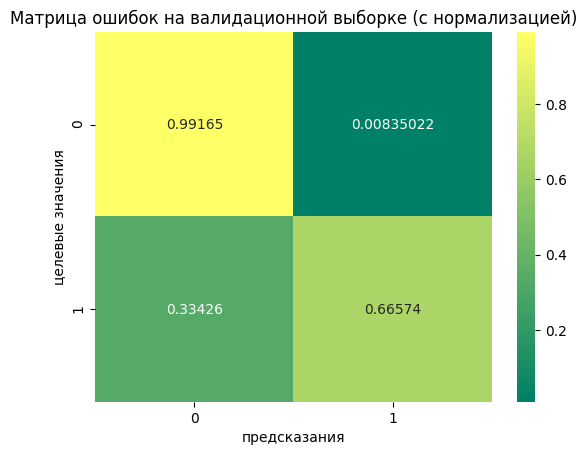

In [28]:
# построим матрицу ошибок
cm = confusion_matrix(target_valid, predictions_valid,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='summer')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

Значение метрики F1 - 0.77 удовлетворяет требованиям заказчика (F1 не менее 0.75).

Модель CatBoost хорошо показывает себя при определении 0 класса на валидационной выборке (0.99 объектов определено верно), но при определении 1 класса, а это токсичные комментарии, модель показывает всего 0.67, то есть 0.33 "плохих" комментариев не будут отправлены на модерацию. 

#### LogisticRegression

In [29]:
params_lr = {}
params_lr['C'] = [1, 10, 100]

In [30]:
%%time
lr_grid = gridsearch(LogisticRegression(random_state=SEED, solver='liblinear', penalty='l2', class_weight='balanced'), 
                       params_lr, features_train, target_train)

Лучшие параметры модели: {'C': 10}
LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear') F1: 0.77
CPU times: total: 3.3 s
Wall time: 24.5 s


In [31]:
logreg = LogisticRegression(random_state=SEED, C=10.0, solver='liblinear', penalty='l2', class_weight='balanced') 

In [32]:
%%time
logreg.fit(features_train, target_train)

CPU times: total: 3 s
Wall time: 3.06 s


LogisticRegression(C=10.0, class_weight='balanced', random_state=12345,
                   solver='liblinear')

In [33]:
print('Результат кросс-валидации')
cross = cross_val_score(logreg, features_train, target_train, cv=5)
print(cross)
print(cross.mean())

Результат кросс-валидации
[0.95103322 0.95197489 0.95087628 0.95391054 0.95291409]
0.9521418039664595


In [34]:
%%time
predictions_valid = logreg.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid, average='weighted')
models_simile.append([round(f1,2), round(roc_auc,2)])
print("F1 на валидационной выборке: %.2f" % f1)
print("ROC_AUC на валидационной выборке: %.2f" % roc_auc)

F1 на валидационной выборке: 0.77
ROC_AUC на валидационной выборке: 0.89
CPU times: total: 46.9 ms
Wall time: 38.9 ms


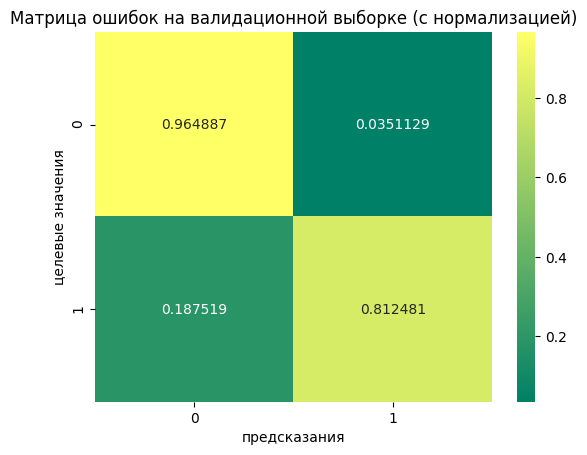

In [35]:
# построим матрицу ошибок
cm = confusion_matrix(target_valid, predictions_valid,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='summer')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

Логистическая регрессия показывает хорошие результаты, как при определении 0 класса - 0.97, так и 1 класса - 0.81.
Значение метрики F1 0.77 удовлетворяет требованиям заказчика (F1 не менее 0.75).
ROC_AUC у данной модели выше, чем у CatBoost.
Также большим преимуществом модели является быстрота обучения и предсказания.

#### LGBMClassifier

In [36]:
params_lgbm = {}
params_lgbm['n_estimators'] = [100, 500]
params_lgbm['random_seed'] = [SEED]
params_lgbm['learning_rate'] = [0.03]
params_lgbm['objective'] = ['binary']
params_lgbm['is_unbalance'] = [True]

In [37]:
%%time
lgbm_grid = gridsearch(LGBMClassifier(), params_lgbm, features_train, target_train)

Лучшие параметры модели: {'is_unbalance': True, 'learning_rate': 0.03, 'n_estimators': 500, 'objective': 'binary', 'random_seed': 12345}
LGBMClassifier() F1: 0.72
CPU times: total: 8min 45s
Wall time: 7min 34s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [38]:
lgbm_model = LGBMClassifier(random_state=SEED, learning_rate= 0.03, n_estimators=500, objective='binary', is_unbalance=True)

In [39]:
%%time
lgbm_model.fit(features_train, target_train)

CPU times: total: 8min 43s
Wall time: 2min 39s


LGBMClassifier(is_unbalance=True, learning_rate=0.03, n_estimators=500,
               objective='binary', random_state=12345)

In [40]:
print('Результат кросс-валидации')
cross = cross_val_score(lgbm_model, features_train, target_train, cv=3)
print(cross)
print(cross.mean())

Результат кросс-валидации
[0.93307803 0.93427083 0.93354887]
0.9336325778977547


In [41]:
%%time
predictions_valid = lgbm_model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid, average='weighted')
models_simile.append([round(f1,2), round(roc_auc,2)])
print("F1 на валидационной выборке: %.2f" % f1)
print("ROC_AUC на валидационной выборке: %.2f" % roc_auc)

F1 на валидационной выборке: 0.73
ROC_AUC на валидационной выборке: 0.90
CPU times: total: 8.88 s
Wall time: 2.74 s


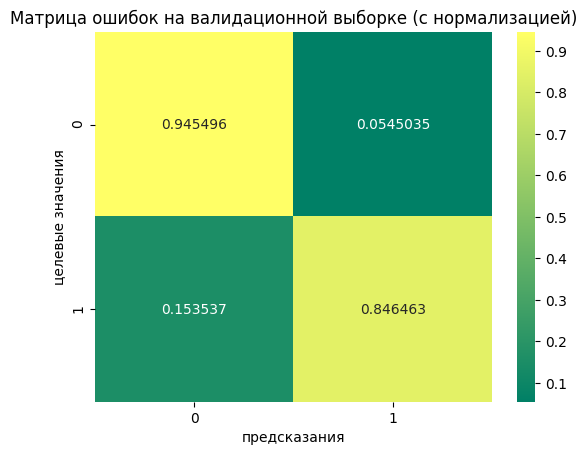

In [42]:
# построим матрицу ошибок
cm = confusion_matrix(target_valid, predictions_valid,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='summer')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

Модель LGBMClassifier на валидационной выборке показывает низкое значение F1 - 0.73. Несмотря на это у модели самый высокий ROC_AUC - 0.90 (из обученных). Целевой класс 1 модель определяет лучше, чем остальные.

Далее попробуем объединить преимущества моделей LogisticRegression (метрика F1 выше 0.75), LGBMClassifier (высокая точность определение класса 1).

#### VotingClassifier с LogisticRegression и LGBMClassifier

Попробуем повысить качество предсказаний с помощью объединения ранее обученных моделей LogisticRegression, LGBMClassifier - обучим модель VotingClassifier.

In [43]:
clf1 = logreg
clf2 = lgbm_model

In [44]:
vc_model = VotingClassifier(estimators=[('lr', clf1), ('lgbm', clf2)], voting='soft', n_jobs=-1)

In [45]:
%%time
vc_model.fit(features_train, target_train)

CPU times: total: 422 ms
Wall time: 2min 52s


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10.0,
                                                 class_weight='balanced',
                                                 random_state=12345,
                                                 solver='liblinear')),
                             ('lgbm',
                              LGBMClassifier(is_unbalance=True,
                                             learning_rate=0.03,
                                             n_estimators=500,
                                             objective='binary',
                                             random_state=12345))],
                 n_jobs=-1, voting='soft')

In [46]:
print('Результат кросс-валидации')
cross = cross_val_score(vc_model, features_train, target_train, cv=3)
print(cross)
print(cross.mean())

Результат кросс-валидации
[0.95144077 0.95235106 0.95420303]
0.9526649507188147


In [47]:
%%time
predictions_valid = vc_model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid, average='weighted')
models_simile.append([round(f1,2), round(roc_auc,2)])
print("F1 на валидационной выборке: %.2f" % f1)
print("ROC_AUC на валидационной выборке: %.2f" % roc_auc)

F1 на валидационной выборке: 0.78
ROC_AUC на валидационной выборке: 0.90
CPU times: total: 8.61 s
Wall time: 2.36 s


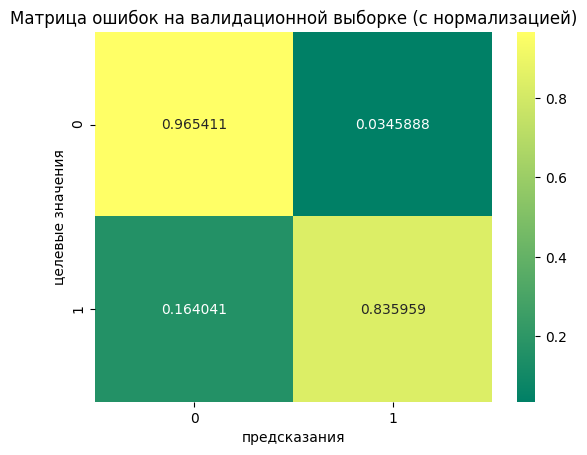

In [48]:
# построим матрицу ошибок
cm = confusion_matrix(target_valid, predictions_valid,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='summer')

plt.title('Матрица ошибок на валидационной выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

С помощью модели VotingClassifier удалось повысить метрику F1 до 0.78 и сохранить AUC на уровни 0.9.

Далее сравним модели и выберем лучшую для тестирования.

#### Сравнение метрик обученных моделей и выбор лучшей модели

Сравним результаты обученных моделей по метрикам F1 и ROC_AUC:

In [49]:
models_all = pd.DataFrame(models_simile, 
                                   columns=['F1', 'ROC_AUC'], 
                                   index=['CatBoost', 'LogReg', 'LGBM','Voting'])
models_all

,F1,ROC_AUC
CatBoost,0.77,0.83
LogReg,0.77,0.89
LGBM,0.73,0.90
Voting,0.78,0.90


Модель с лучшими показателями F1 и ROC_AUC - VotingClassifier.

Используем ее для тестирования.

#### Тестирование лучшей модели

In [50]:
%%time
predictions_test = vc_model.predict(features_test)
f1 = f1_score(target_test, predictions_test)
roc_auc = roc_auc_score(target_test, predictions_test, average='weighted')
print("F1 на тестовой выборке: %.2f" % f1)
print("ROC_AUC на тестовой выборке: %.2f" % roc_auc)

F1 на тестовой выборке: 0.79
ROC_AUC на тестовой выборке: 0.91
CPU times: total: 8.47 s
Wall time: 2.28 s


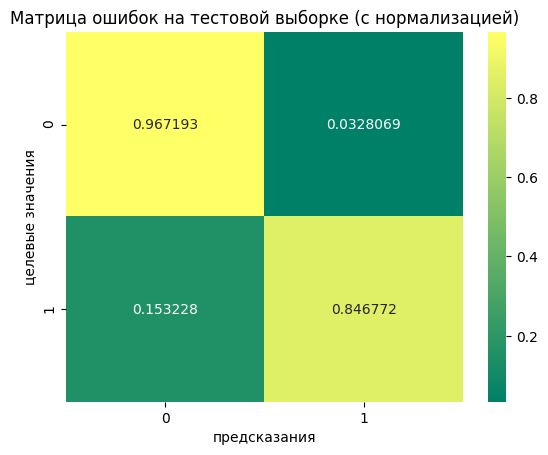

In [51]:
# построим матрицу ошибок
cm = confusion_matrix(target_test, predictions_test,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='summer')

plt.title('Матрица ошибок на тестовой выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

Выбранная модель показала хорошие результаты при тестировании:
- F1 на тестовой выборке: 0.79;
- ROC_AUC на тестовой выборке: 0.91.

Модель соответствует целевому уровню F1 (не менее 0.75).

Далее приведем пример корректировки порогового значения для определения классов с целью повышения полноты выявления токсичных комментариев.

#### *Дополнительно: корректировка порогового значения

С помощью корректировки порогового значения при определении класса попробуем улучшить полноту предсказания класса 1 (токсичные комментарии).

In [52]:
predict_proba = vc_model.predict_proba(features_test)[:,1]

In [53]:
f1 = []
auc = []
for threshold in np.arange(0, 1.01, 0.01):
    predict = predict_proba > threshold
    f1.append([float('{:.2f}'.format(threshold)),float('{:.4f}'.format(f1_score(target_test, predict)))])
    auc.append([float('{:.2f}'.format(threshold)),float('{:.4f}'.format(roc_auc_score(target_test, predict, 
                                                                                      average='weighted')))])

Вручную подберем пороговое значение с максимальным F1 и без потери качества ROC_AUC:

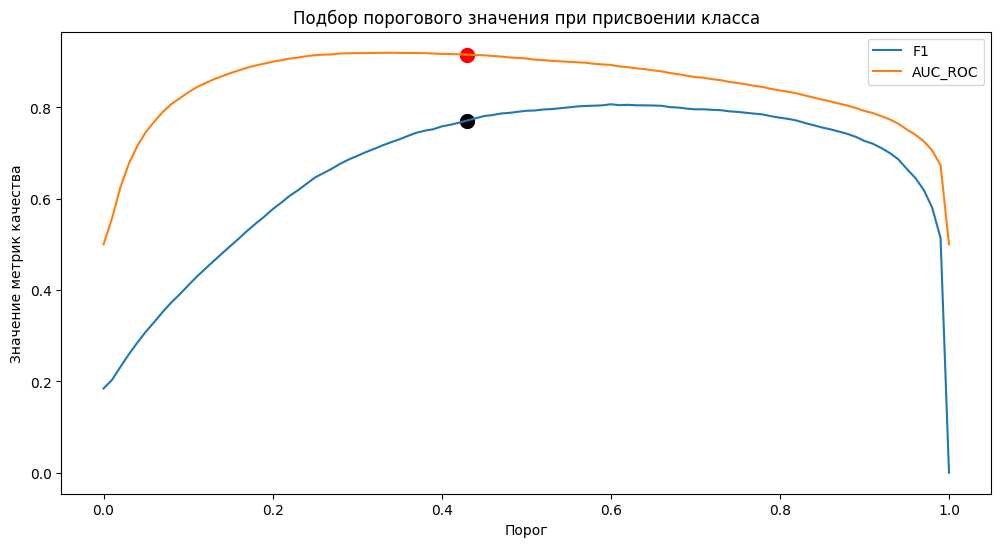

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.array(f1)[:,0], np.array(f1)[:,1], label = 'F1')
ax.plot(np.array(auc)[:,0], np.array(auc)[:,1], label = 'AUC_ROC')
ax.scatter(0.43, 0.915, c='r', lw = 5)
ax.scatter(0.43, 0.77, c='black', lw = 5)
ax.legend()
plt.xlabel('Порог')
plt.ylabel('Значение метрик качества')
plt.title('Подбор порогового значения при присвоении класса')

plt.show()

In [55]:
predict = predict_proba > 0.43
print('F1: {:.4f}'.format(f1_score(target_test, predict)))
roc_auc = roc_auc_score(target_test, predict, average='weighted')
print("ROC_AUC: %.2f" % roc_auc)

F1: 0.7713
ROC_AUC: 0.92


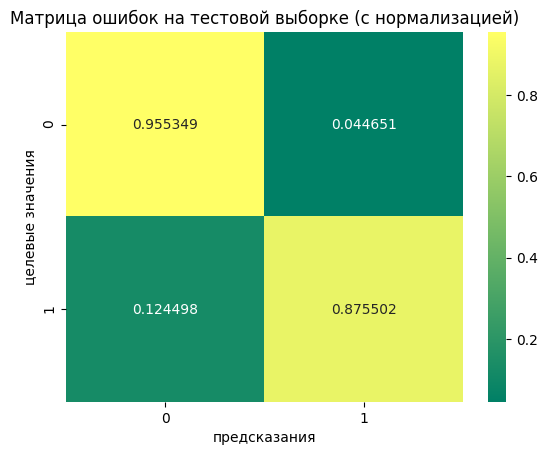

In [56]:
# построим матрицу ошибок
cm = confusion_matrix(target_test, predict,  normalize='true')
sns.heatmap(cm, annot=True,  fmt='g', cmap='summer')

plt.title('Матрица ошибок на тестовой выборке (с нормализацией)')
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

По итогам корректировки порогового значения удалось улучшить полноту предсказания 1-го класса с 0.85 до 0.88 (на 0.03 процентных пункта). При этом полнота определения класса 0 снизилась незначительно - с 0.97 до 0.96 (на 0.01 процентных пункта).

При этом метрика F1 снизилась с 0.79 до 0.77 (на 0.02 п.п.), а ROC_AUC выросла на 0.01 п.п. - с 0.91 до 0.92.

Модель удовлетворяет требованиям заказчика - F1 не менее 0.75.

Такая корректировка модели позволит выявлять больший процент токсичных комментариев.

## Выводы

В ходе выполнения проекта было реализовано:
- загружены и подготовлены для обучения данные;
- подготовлены признаки для обучения с помощью TfidfVectorizer, удалены стоп-слова;
- подобраны гиперпараметры и обучены следующие модели (результат на валидационной выборке):	
    - CatBoostClassifier: F1 - 0.77, ROC_AUC - 0.83;
    - LogisticRegression:	F1 - 0.77, ROC_AUC - 0.89;
    - LGBMClassifier:	F1 - 0.73,	ROC_AUC - 0.90;
    - VotingClassifier:	F1 - 0.78, ROC_AUC - 0.90.
- выбрана модель с лучшими показателями (VotingClassifier) и протестирована на тестовой выборке:
    - F1 на тестовой выборке: 0.79 (модель соответствует целевому уровню F1 - не менее 0.75);
    - ROC_AUC на тестовой выборке: 0.91.
- скорректировано пороговое значение для улучшения полноты предсказания 1-го класса - с 0.85 до 0.88 (на 0.03 процентных пункта). Такая корректировка модели позволит выявлять больший процент токсичных комментариев.

**Итоговые показатели качества модели VotingClassifier с LogisticRegression и LGBMClassifier:**
- F1: 0.77
- ROC_AUC: 0.92


Модель удовлетворяет требованиям заказчика - F1 не менее 0.75.